In [1]:
from funcs.auroralring import AuroralRing
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import emcee
import corner

def get_full_rotation_line(ring, n=100, alpha=np.linspace(0, 2*np.pi, 100).reshape(100,1)):

    full_flux_analytical = ring.get_flux_analytically(alpha)

    mf = np.max(full_flux_analytical)
    
    if mf != 0:
        full_flux_analytical /= mf

    return full_flux_analytical

# dark mode
plt.style.use('dark_background')

from multiprocessing import Pool

In [2]:
# set up the ring
logf_true = np.log(0.5)
i_rot_true = 60/180*np.pi
i_mag_true = 15 * np.pi/180
latitude_true = 85.5*np.pi/180
n=100
P_rot= 1.5 * np.pi
omega = 2*np.pi/P_rot
Rstar = 1
vmax = omega * Rstar * 695700. / 86400.
v_bins = np.linspace(-vmax*1.05, vmax*1.05, 100)
v_mids = (v_bins[1:] + v_bins[:-1])/2
phi = np.linspace(0, 2*np.pi, 1800)
convert_to_kms = omega / 86400 * Rstar * 695700.

ring = AuroralRing(i_rot=i_rot_true, i_mag=i_mag_true, latitude=latitude_true,
                   width=1 * np.pi/180, Rstar=1, P_rot=1.5 * np.pi, N=60, 
                   norm=11, gridsize=int(4e5), v_bins=v_bins, v_mids=v_mids,
                   phi=phi, omega=omega, convert_to_kms=convert_to_kms)

ring.get_flux_analytically(np.linspace(0, 2*np.pi, 100).reshape(100,1))


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.19661529, 0.57573061, 0.65638574,
       0.82127301, 0.99992114, 0.7144125 , 0.65318195, 0.62849826,
       0.61523929, 0.62844246, 0.65319863, 0.71426875, 1.        ,
       0.82161184, 0.65590252, 0.57575506, 0.19666633, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Text(0, 0.5, 'normalized flux')

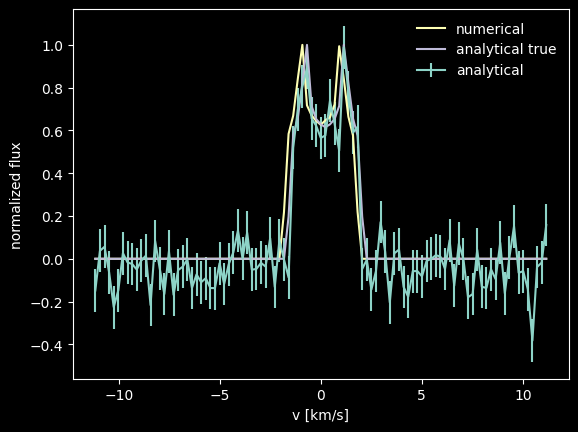

In [5]:
ffa_ = get_full_rotation_line(ring, n=n)

# calculate the flux 
# this serves as measurement
full_flux_numerical = np.zeros_like(ring.v_mids)

for alpha in np.linspace(0, 2*np.pi, n):
    full_flux_numerical += ring.get_flux_numerically(alpha)

flux_err = np.ones_like(full_flux_numerical) * 0.1
ffa =  ffa_ - 0.05 + np.random.randn(len(ffa_)) * 0.1
full_flux_numerical /= np.max(full_flux_numerical)

plt.errorbar(ring.v_mids, ffa, yerr = flux_err, label='analytical')
plt.plot(ring.v_mids, full_flux_numerical, label='numerical')
plt.plot(ring.v_mids, ffa_, label='analytical true')
plt.legend(frameon=False)
plt.xlabel('v [km/s]')
plt.ylabel('normalized flux')

In [5]:
%timeit get_full_rotation_line(ring, n=n)

7.66 ms ± 80.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


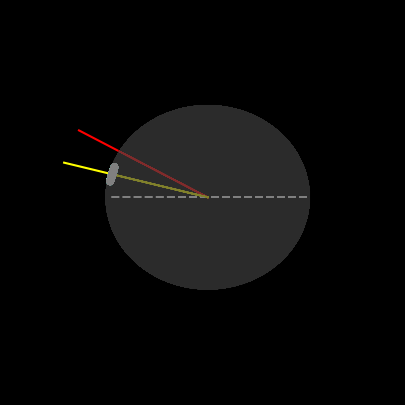

In [6]:
fig, ax = ring.plot_setup_sphere()

ring.plot_sphere_with_auroral_ring(ax, alpha=alpha)
ring.plot_layout_sphere(ax, view="observer left")


In [ ]:
def log_likelihood(theta, ffa, flux_err, v_bins, v_mids, phi, omega):

    i_rot, i_mag, latitude, log_f = theta
    ring = AuroralRing(i_rot=i_rot, i_mag=i_mag, latitude=latitude,
                   width=1 * np.pi/180, Rstar=1, P_rot=1.5 * np.pi, N=60, 
                   norm=11, gridsize=0, v_bins=v_bins, v_mids=v_mids,
                   phi=phi, omega=omega, convert_to_kms=convert_to_kms)
    model = get_full_rotation_line(ring, n=100)
    # plt.plot(ring.v_mids, model, c="w", alpha=0.05)
    
    sigma2 = flux_err**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((ffa - model) ** 2 / sigma2 + np.log(sigma2))

In [ ]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([i_rot_true, i_mag_true, latitude_true, logf_true]) + 0.01 * np.random.randn(4)
soln = minimize(nll, initial, args=(ffa, flux_err, v_bins, v_mids, phi, omega))
i, m, l, lf = soln.x

print("Maximum likelihood estimates:")
print("i_rot = {0:.3f}".format(i*180/np.pi))
print("logf = {0:.3f}".format(lf))
print("m = {0:.3f}".format(m*180/np.pi))
print("l = {0:.3f}".format(l*180/np.pi))


Maximum likelihood estimates:
i_rot = 60.141
logf = -1.333
m = 15.247
l = 83.682


In [ ]:
def log_prior(theta):
    i, m, l, logf = theta
    if  0<i<np.pi/2 and 0 < m < np.pi/2 and 0 < l < np.pi/2 and -10 < logf < 1:
        return 0.0
    return -np.inf


def log_probability(theta, y, yerr, v_bins, v_mids, phi, omega):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,  y, yerr, v_bins, v_mids, phi, omega)

In [ ]:

# initialize the walkers
pos = soln.x + 1e-2 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

# parallelize the process
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(ffa, flux_err, v_bins, v_mids, phi, omega),
                                    pool=pool)
    # run MCMC
    sampler.run_mcmc(pos, 10000, progress=True)
    

  6%|▋         | 639/10000 [01:14<18:13,  8.56it/s]


KeyboardInterrupt: 

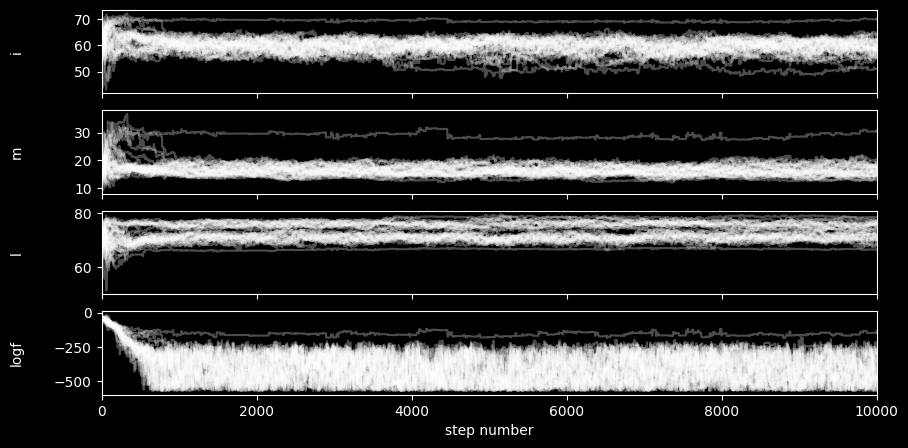

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 5), sharex=True)
samples = sampler.get_chain()
labels = ["i", "m", "l", "logf"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i]*180/np.pi, "w", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

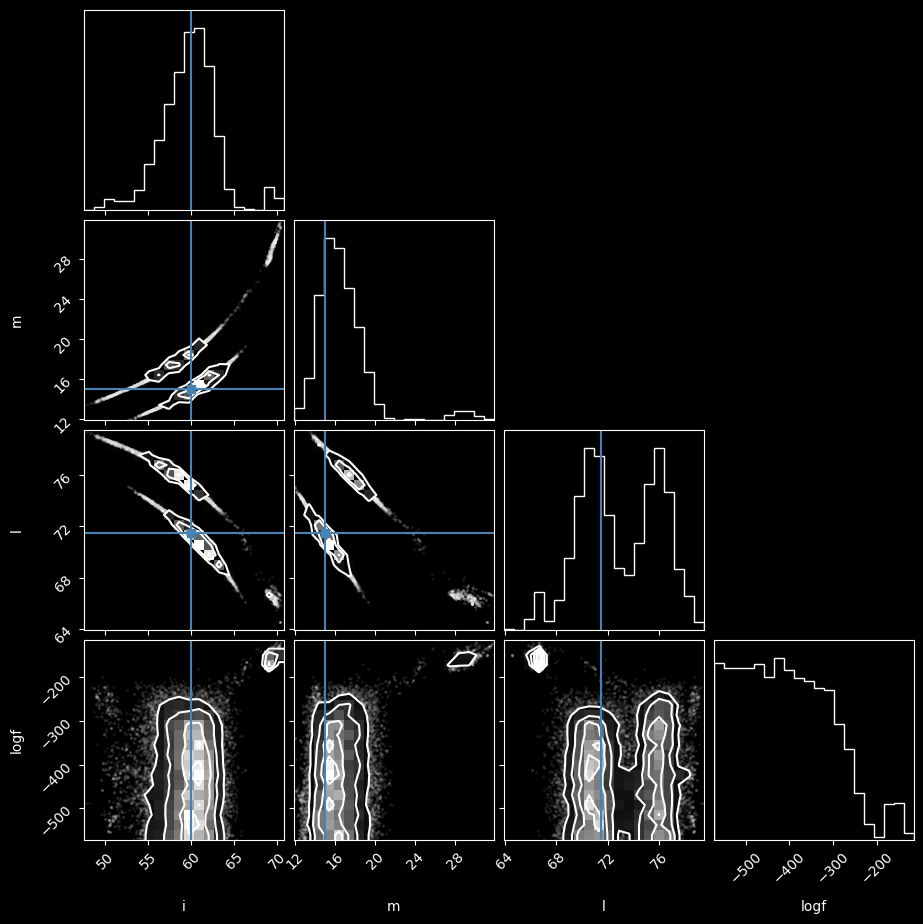

In [ ]:
flat_samples = sampler.get_chain(discard=400, thin=15, flat=True)


fig = corner.corner(
    flat_samples*180/np.pi, labels=labels, truths=np.array([i_rot_true, i_mag_true, latitude_true, logf_true])*180/np.pi);